In [1]:
#importing packadges
import pandas as pd
import numpy as np
import csv
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#loading the dataset from "tmbd_movies.csv"
df = pd.read_csv('tmdb-movies.csv')

#printing data header
df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


>dropping unuseful data

In [3]:
column_drop=[ 'id', 'imdb_id', 'popularity', 'homepage', 'tagline','keywords', 'overview', 'production_companies', 'release_date', 'vote_count', 'vote_average','budget_adj', 'revenue_adj']
df.drop(column_drop, axis = 1, inplace = True)
df.head(2)

,budget,revenue,original_title,cast,director,runtime,genres,release_year
0,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,2015
1,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,2015


>checking data types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10571 entries, 10172 to 0
Data columns (total 8 columns):
budget            10571 non-null int64
revenue           10571 non-null int64
original_title    10571 non-null object
cast              10495 non-null object
director          10527 non-null object
runtime           10571 non-null int64
genres            10548 non-null object
release_year      10571 non-null int64
dtypes: int64(4), object(4)
memory usage: 743.3+ KB


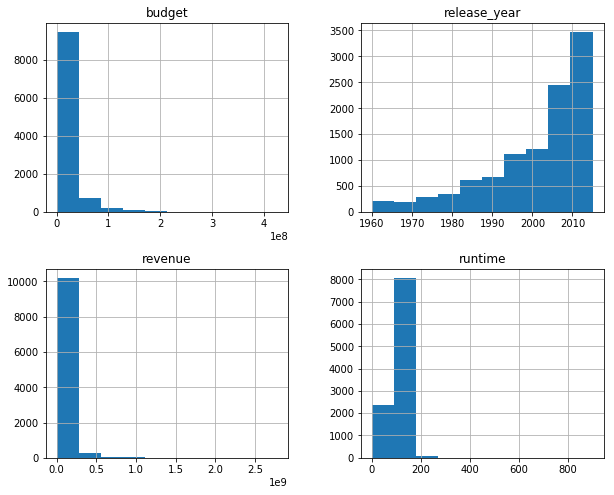

In [6]:
df.info()
df.hist(figsize=(10,8));

In [7]:
# sorting by release year
df.sort_values("release_year", inplace = True)

# dropping duplicate movies
df.drop_duplicates(subset ="original_title", keep = 'first', inplace = True)
 
# displaying data
df.head(2)


,budget,revenue,original_title,cast,director,runtime,genres,release_year
10172,0,0,Exodus,Paul Newman|Eva Marie Saint|Lee J. Cobb|Ralph ...,Otto Preminger,208,Action|Drama|History|War,1960
10164,0,0,The Lost World,Michael Rennie|Jill St. John|David Hedison|Cla...,Irwin Allen,97,Adventure|Fantasy|Science Fiction,1960


In [8]:
df.shape

(10571, 8)

In [9]:
#dropping zero values of budget and revenue
df['budget'] = df['budget'].replace(0, np.nan)
df['revenue'] = df['revenue'].replace(0, np.nan)
df['release_year'] = df['release_year'].replace(0, np.nan)

In [10]:
zero_list = ['budget','revenue','release_year']
df.dropna(subset = zero_list, inplace = True)

In [11]:
df.shape

(3696, 8)

In [12]:
df.head(4)

,budget,revenue,original_title,cast,director,runtime,genres,release_year
10170,3000000.0,7100000.0,Cinderfella,Jerry Lewis|Ed Wynn|Judith Anderson|Henry Silv...,Frank Tashlin,91,Comedy|Romance,1960
10142,2000000.0,4905000.0,The Magnificent Seven,Yul Brynner|Eli Wallach|Steve McQueen|Charles ...,John Sturges,128,Action|Adventure|Western,1960
10143,12000000.0,60000000.0,Spartacus,Kirk Douglas|Laurence Olivier|Jean Simmons|Cha...,Stanley Kubrick,197,Action|Drama|History,1960
10144,3000000.0,25000000.0,The Apartment,Jack Lemmon|Shirley MacLaine|Fred MacMurray|Ra...,Billy Wilder,125,Comedy|Drama|Romance,1960


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3696 entries, 10170 to 0
Data columns (total 8 columns):
budget            3696 non-null float64
revenue           3696 non-null float64
original_title    3696 non-null object
cast              3692 non-null object
director          3695 non-null object
runtime           3696 non-null int64
genres            3696 non-null object
release_year      3696 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 259.9+ KB


In [14]:
#calculating profit
df.insert(2,'earned_value',df['revenue'] - df['budget'])
df.head(2)

,budget,revenue,earned_value,original_title,cast,director,runtime,genres,release_year
10170,3000000.0,7100000.0,4100000.0,Cinderfella,Jerry Lewis|Ed Wynn|Judith Anderson|Henry Silv...,Frank Tashlin,91,Comedy|Romance,1960
10142,2000000.0,4905000.0,2905000.0,The Magnificent Seven,Yul Brynner|Eli Wallach|Steve McQueen|Charles ...,John Sturges,128,Action|Adventure|Western,1960


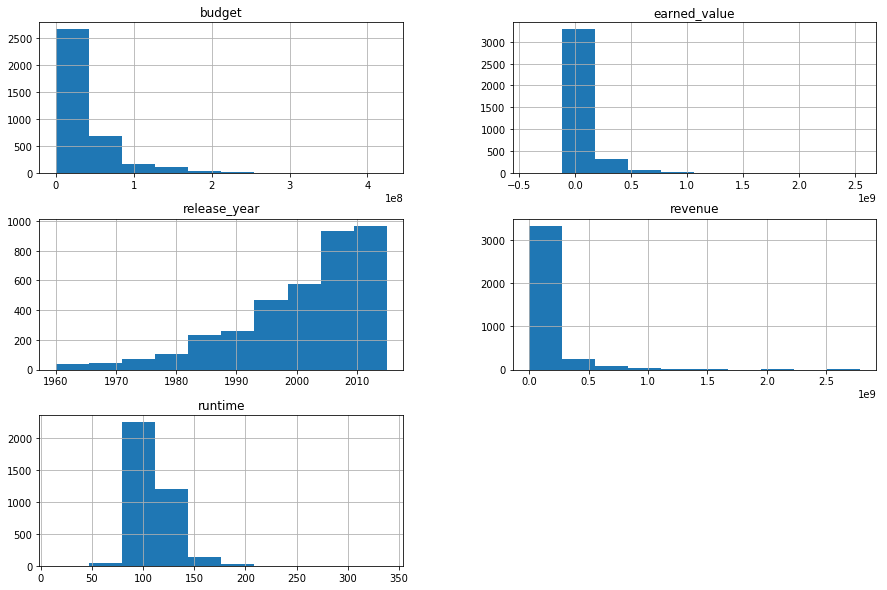

In [15]:
df.hist(figsize=(15,10));

In [16]:
import pprint
#defining a function to calculate high and low values
def high_low(column):
    high= df[column].idxmax()
    high_details=pd.DataFrame(df.loc[high])
        
    low= df[column].idxmin()
    low_details=pd.DataFrame(df.loc[low])
    
    values = pd.concat([high_details, low_details], axis=1)
    
    return values

#calling the function
high_low('earned_value')

,1386,2244
budget,2.37e+08,4.25e+08
revenue,2.78151e+09,1.10876e+07
earned_value,2.54451e+09,-4.13912e+08
original_title,Avatar,The Warrior's Way
cast,Sam Worthington|Zoe Saldana|Sigourney Weaver|S...,Kate Bosworth|Jang Dong-gun|Geoffrey Rush|Dann...
director,James Cameron,Sngmoo Lee
runtime,162,100
genres,Action|Adventure|Fantasy|Science Fiction,Adventure|Fantasy|Action|Western|Thriller
release_year,2009,2010


In [17]:
df_dtype = ['budget', 'revenue','earned_value']
df[df_dtype] = df[df_dtype].applymap(np.int64)

In [18]:
df.head(4)

,budget,revenue,earned_value,original_title,cast,director,runtime,genres,release_year
10170,3000000,7100000,4100000,Cinderfella,Jerry Lewis|Ed Wynn|Judith Anderson|Henry Silv...,Frank Tashlin,91,Comedy|Romance,1960
10142,2000000,4905000,2905000,The Magnificent Seven,Yul Brynner|Eli Wallach|Steve McQueen|Charles ...,John Sturges,128,Action|Adventure|Western,1960
10143,12000000,60000000,48000000,Spartacus,Kirk Douglas|Laurence Olivier|Jean Simmons|Cha...,Stanley Kubrick,197,Action|Drama|History,1960
10144,3000000,25000000,22000000,The Apartment,Jack Lemmon|Shirley MacLaine|Fred MacMurray|Ra...,Billy Wilder,125,Comedy|Drama|Romance,1960


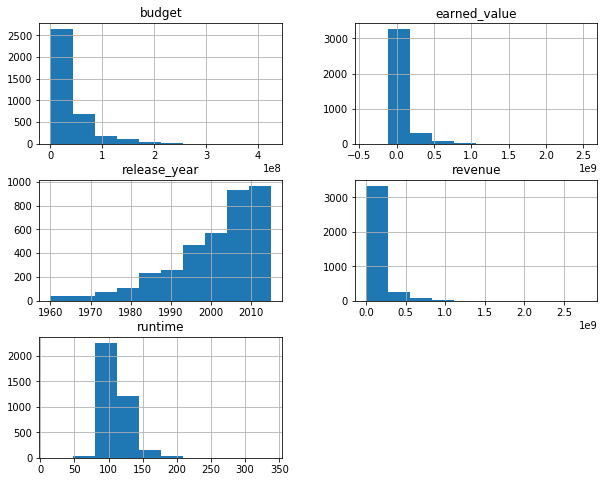

In [19]:
df.hist(figsize = (10,8));

>release year and earned value

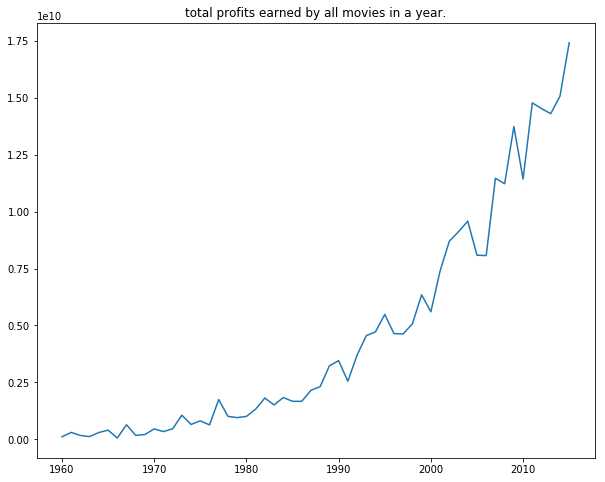

In [20]:
profit_per_year = df.groupby('release_year')['earned_value'].sum()
df['earned_value']
plt.figure(figsize=(10,8))
plt.title('total profits earned by all movies in a year.')
plt.plot(profit_per_year)
plt.show()

>checking the average of budget, revenue and earned value

In [21]:
avg_budget = int(df['budget'].mean())
print(avg_budget)

36574499


In [22]:
avg_revenue = int(df['revenue'].mean())
print(avg_revenue)

105501201


In [23]:
avg_profit = int(df['earned_value'].mean())
print(avg_profit)

68926701


>showing high and low budget movies

In [24]:
high_low('budget')

,2244,2618
budget,425000000,1
revenue,11087569,100
earned_value,-413912431,99
original_title,The Warrior's Way,Lost & Found
cast,Kate Bosworth|Jang Dong-gun|Geoffrey Rush|Dann...,David Spade|Sophie Marceau|Ever Carradine|Step...
director,Sngmoo Lee,Jeff Pollack
runtime,100,95
genres,Adventure|Fantasy|Action|Western|Thriller,Comedy|Romance
release_year,2010,1999


>show longest and shortest runtime

In [25]:
high_low('runtime')

,2107,5162
budget,18000000,10
revenue,871279,5
earned_value,-17128721,-5
original_title,Carlos,Kid's Story
cast,Edgar RamÃ­rez|Alexander Scheer|Fadi Abi Samra...,Clayton Watson|Keanu Reeves|Carrie-Anne Moss|K...
director,Olivier Assayas,Shinichiro Watanabe
runtime,338,15
genres,Crime|Drama|Thriller|History,Science Fiction|Animation
release_year,2010,2003


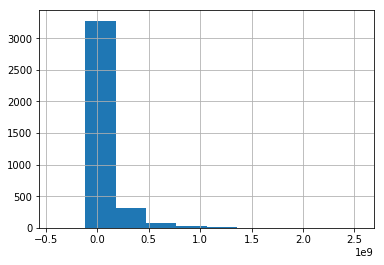

In [26]:
df['earned_value'].hist();

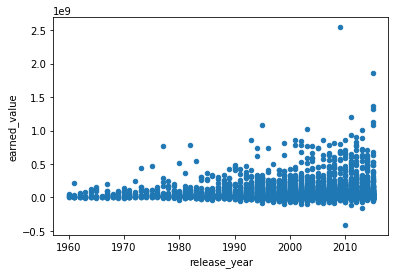

In [27]:
df.plot(x='release_year',y='earned_value',kind='scatter');